This notebook demonstrates how to remove cosmic rays from the 1D spectra produced by long_slit_science_extraction.py.

First (as with all ipython notebooks), turn on interactive plotting through:

In [75]:
%matplotlib nbagg

Now load remaining useful modules:

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import reduction_utils.cosmic_removal as c
import reduction_utils.wavelength_calibration as wc

Now load in the 1D spectra (with errors) for the target (star1) and comparison (star2). This is assuming that the pickled objects (numpy arrays) are stored in '../pickled_objects/'. For this example, we're using data of HAT-P-44b.

In [77]:
parent_direc = '/Users/james/ACAMdata/hat44/20180326/reduction12/no_flat/'

s1 = pickle.load(open(parent_direc+'pickled_objects/star1_flux.pickle','rb'))
s2 = pickle.load(open(parent_direc+'pickled_objects/star2_flux.pickle','rb'))

e1 = pickle.load(open(parent_direc+'pickled_objects/star1_error.pickle','rb'))
e2 = pickle.load(open(parent_direc+'pickled_objects/star2_error.pickle','rb'))

First check how badly affected the stellar spectra are by plotting all frames on a single plot. Note that in the below we are noamlising all spectra as otherwise the amplitude of the spectra changes due to changing airmass, observing conditions and exposure time. 

Cosmic rays reveal themselves as sharp features imposed on the stellar spectra. These are more easily identified for spectra with lower S/N where the relative amplitude of the cosmic is larger.

<IPython.core.display.Javascript object>


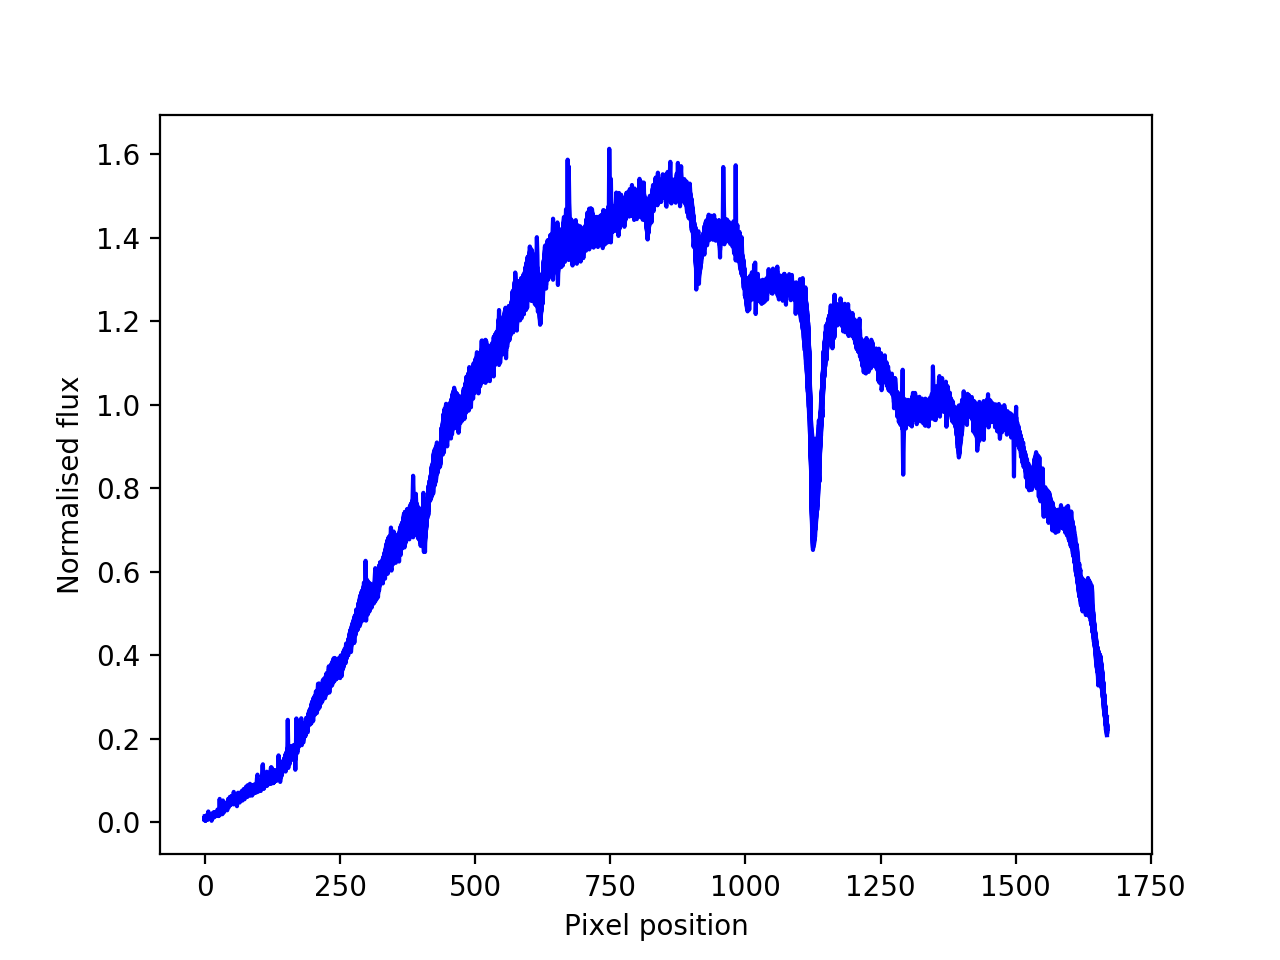

In [78]:
plt.figure()
for i in s1:
    plt.plot(wc.normalise(i),'b')
plt.xlabel('Pixel position')
plt.ylabel('Normalised flux')
plt.show()

In the above example, we can see cosmic rays at (y) pixel positions ~670, 740 and 1000 but otherwise the spectra don't look too badly affected. These have revealed themselves as anomalous emission features.

Now do the same for the second star.

<IPython.core.display.Javascript object>


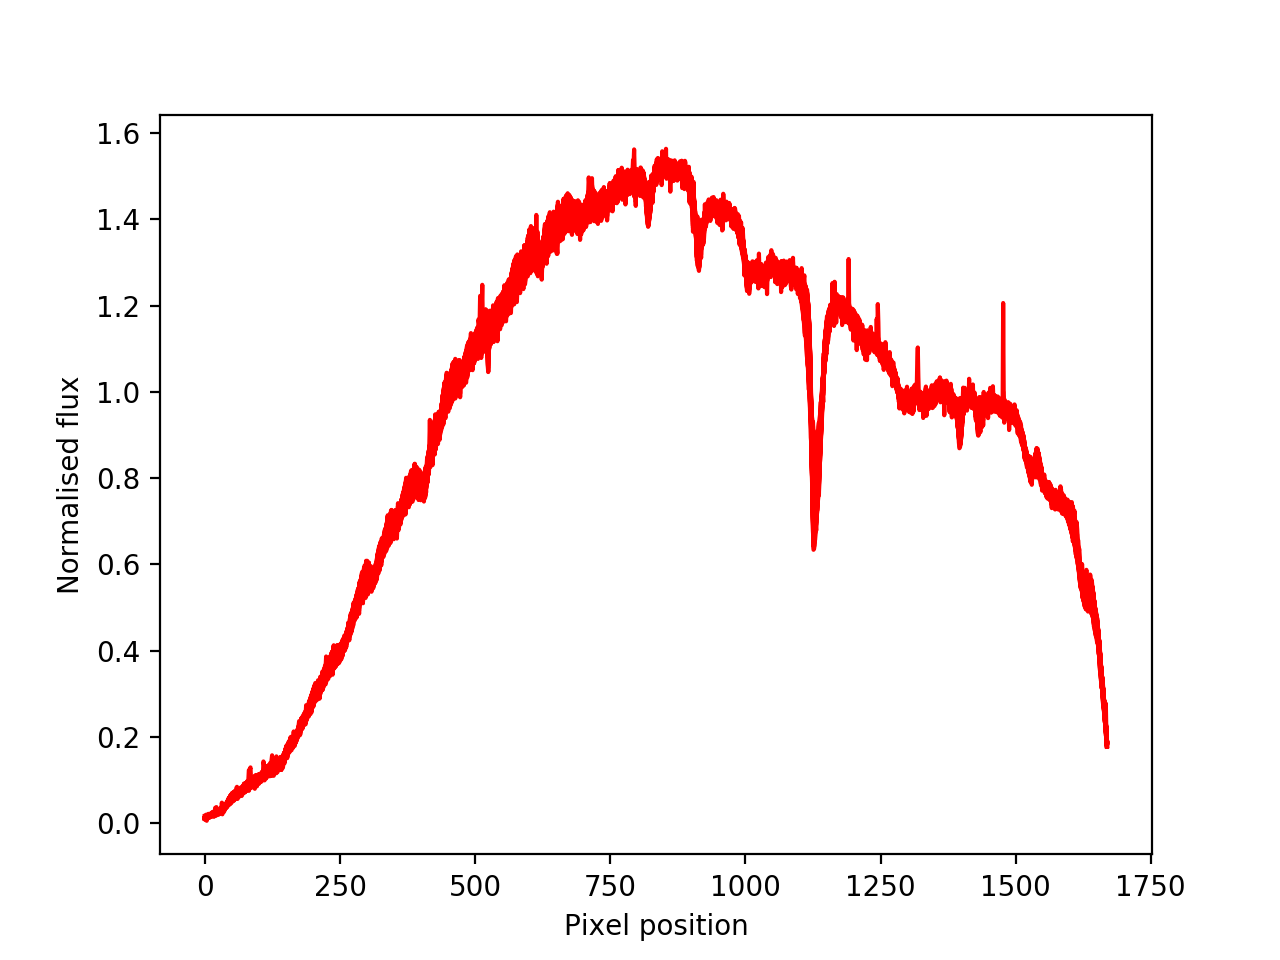

In [79]:
plt.figure()
for i in s2:
    plt.plot(wc.normalise(i),'r')
plt.xlabel('Pixel position')
plt.ylabel('Normalised flux')
plt.show()

Again, these are not too bad with a couple of obvious cosmics around 1200 and 1500.

Now we have 2 methods to locate cosmic rays within the spectra. The first is to divide all spectra by a reference spectrum free of cosmics and the second is to use a running median.

### Method 1) dividing by a reference spectrum 

First we need to define the reference spectrum (typically the spectrum taken midway through the observations) and check that it doesn't contain cosmics.

<IPython.core.display.Javascript object>


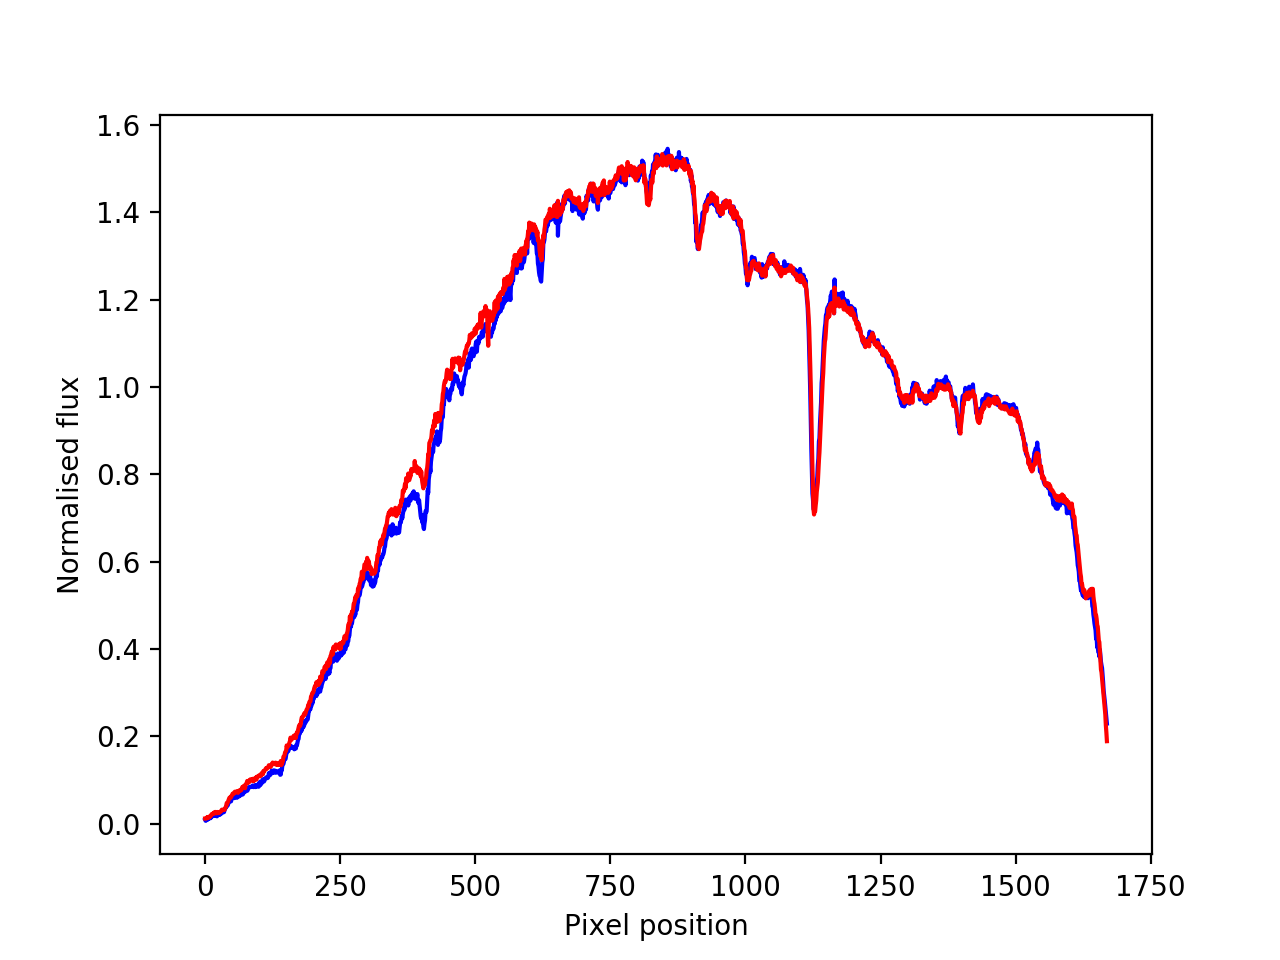

In [80]:
nframes = len(s1)

plt.figure()
plt.plot(wc.normalise(s1[nframes//2]),color='b')
plt.plot(wc.normalise(s2[nframes//2]),color='r')
plt.xlabel('Pixel position')
plt.ylabel('Normalised flux')
plt.show()

These look good. There is a feature at 1162 but this is associated with ACAM's detector and is persistent in all 1D spectra extracted without a flat field.

Now we use these reference spectra to locate the cosmic rays.

In [2]:
help(c.find_cosmic_frames)

Help on function find_cosmic_frames in module reduction_utils.cosmic_removal:

find_cosmic_frames(spectra, errors, ref_frame, clip=3, mad=False, ignore_edges=0, mask=None)
    A function that uses the standard or median absolute deviation of residuals from each spectrum - a reference spectrum to locate cosmic rays.
    This code first normalizes all inputted spectra for the purposes of accurate comparison, although the normalized
    spectra are only used to locate cosmic rays, they are not returned.
    
    Inputs:
    spectra - the ndarray of stellar spectra
    errors - the ndarray of stellar errors
    clip - the number of stds/mads to clip at. Default=3
    mad - True/False, use the median absolute deviation? Default=False: std is used
    ignore_edges - ignore the edges of the spectra where SNR is low? Define this as the number of data points to ignore. Default = 0
    mask - the masked regions to ignore. Strong absorption lines can be masked, as sometimes these are incorrectly 

In [82]:
cosmic_frames_1,cosmic_pixels_1 = c.find_cosmic_frames(data=s1,clip=5,mad=False,\
                                                       mask=[list(range(650,655)),list(range(1092,1166)),\
                                                             list(range(1160,1170))],\
                                                       ignore_edges=250,\
                                                       ref_frame=s1[nframes//2])

In [83]:
print("Cosmic frames = ",cosmic_frames_1)

Cosmic frames =  [ 0 12 14 36 37 42]


Ok so the above have been flagged as containing cosmic rays. Now let's check that these are indeed cosmics.

<IPython.core.display.Javascript object>


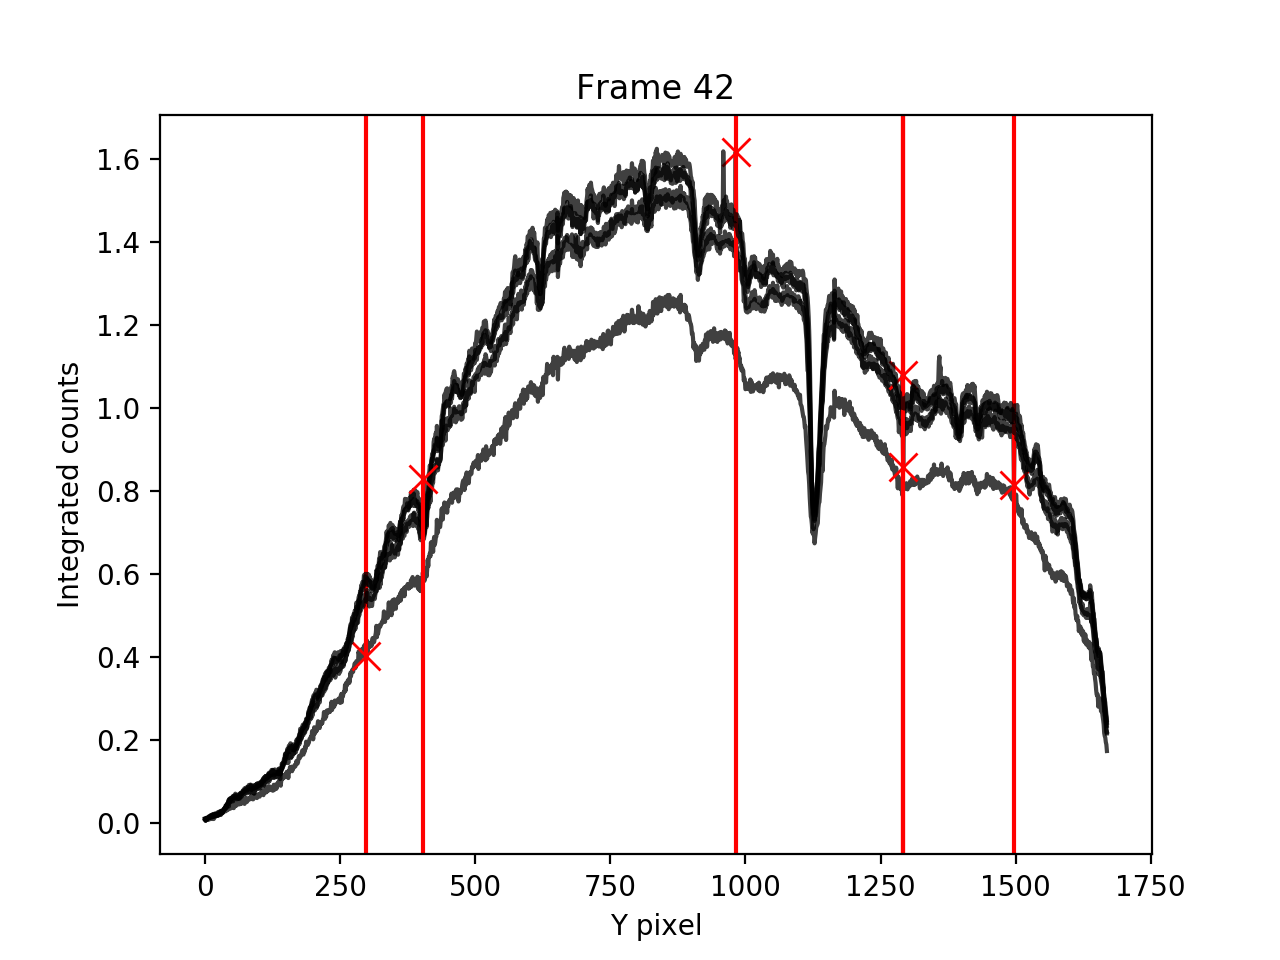

In [84]:
c.check_cosmic_frames(wc.normalise(s1),cosmic_frames_1,cosmic_pixels_1,single_plot=True)

In this case the division has not performed too well. It is struggling to locate all the cosmics while incorrectly flagging others. This can be improved by iterating different parameter values for c.find_cosmic_frames(). For the purposes of this example we will continue for now.

Assuming that the cosmics are all real, we replace them by doing the following:

<IPython.core.display.Javascript object>


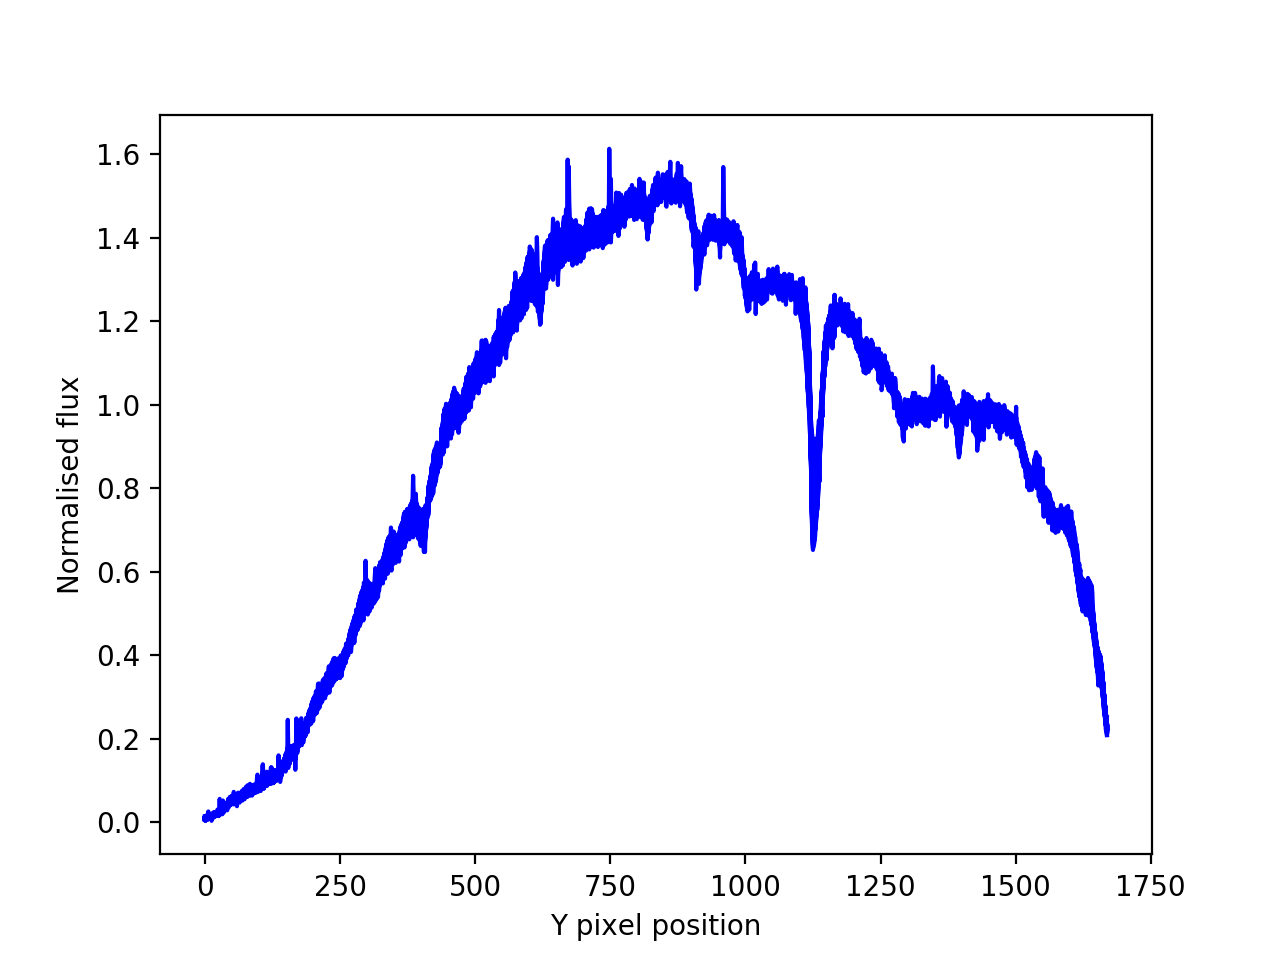

In [85]:
# replace cosmics with interpolated values
s1_copy,e1_copy = c.replace_cosmics(s1,e1,cosmic_frames_1,cosmic_pixels_1)

plt.figure()
for i in s1_copy:
    plt.plot(wc.normalise(i),'b')
plt.ylabel('Normalised flux')
plt.xlabel('Y pixel position')
plt.show()

As mentioned above, this has not done the best job!

We would then perform the same process for the second star.

### Method 2) Using a median filter to perform cosmic removal 

In [86]:
help(c.find_cosmic_frames_with_medfilt)

Help on function find_cosmic_frames_with_medfilt in module reduction_utils.cosmic_removal:

find_cosmic_frames_with_medfilt(data, box_width=7, sigma_clip=5, mask=None, search_region=None, use_mad=True)
    A function to to find cosmic rays within 1D spectra. This is like find_cosmic_frames but instead of dividing by a reference frame, this function finds cosmics via large differences in the running median.
    This should flag up the locations of comsics as large outliers in the residuals, which are identified via setting the sigma_clip (which removes points that sit away from the mean by a user-defined number of standard deviations).
    Strong absorption lines can be masked, as sometimes these are incorrectly flagged as cosmics. The mask is defined as [range(low_pixel,high_pixel),range(low_pixel,high_pixel)...]
    
    Inputs:
    data - the ndarray of 1D spectra
    box_width - the number of data points over which to calculate the running median. This must be an odd number and some

In [87]:
cosmic_frames_1_mf,cosmic_pixels_1_mf = c.find_cosmic_frames_with_medfilt(s1,box_width=7,sigma_clip=9,\
                                                                   mask=[list(range(650,655)),list(range(1160,1170))],\
                                                                         use_mad=False)

print("Cosmic frames = ",cosmic_frames_1_mf)



Cosmic frames =  [ 3  9 12 14 16 21 26 27 32 36 37 42 48 50 56 66 74 77 82 83 84]


Note that in this case, I found the Median Absolute Deviation (MAD) to perform worse, hence use_mad=False.

<IPython.core.display.Javascript object>


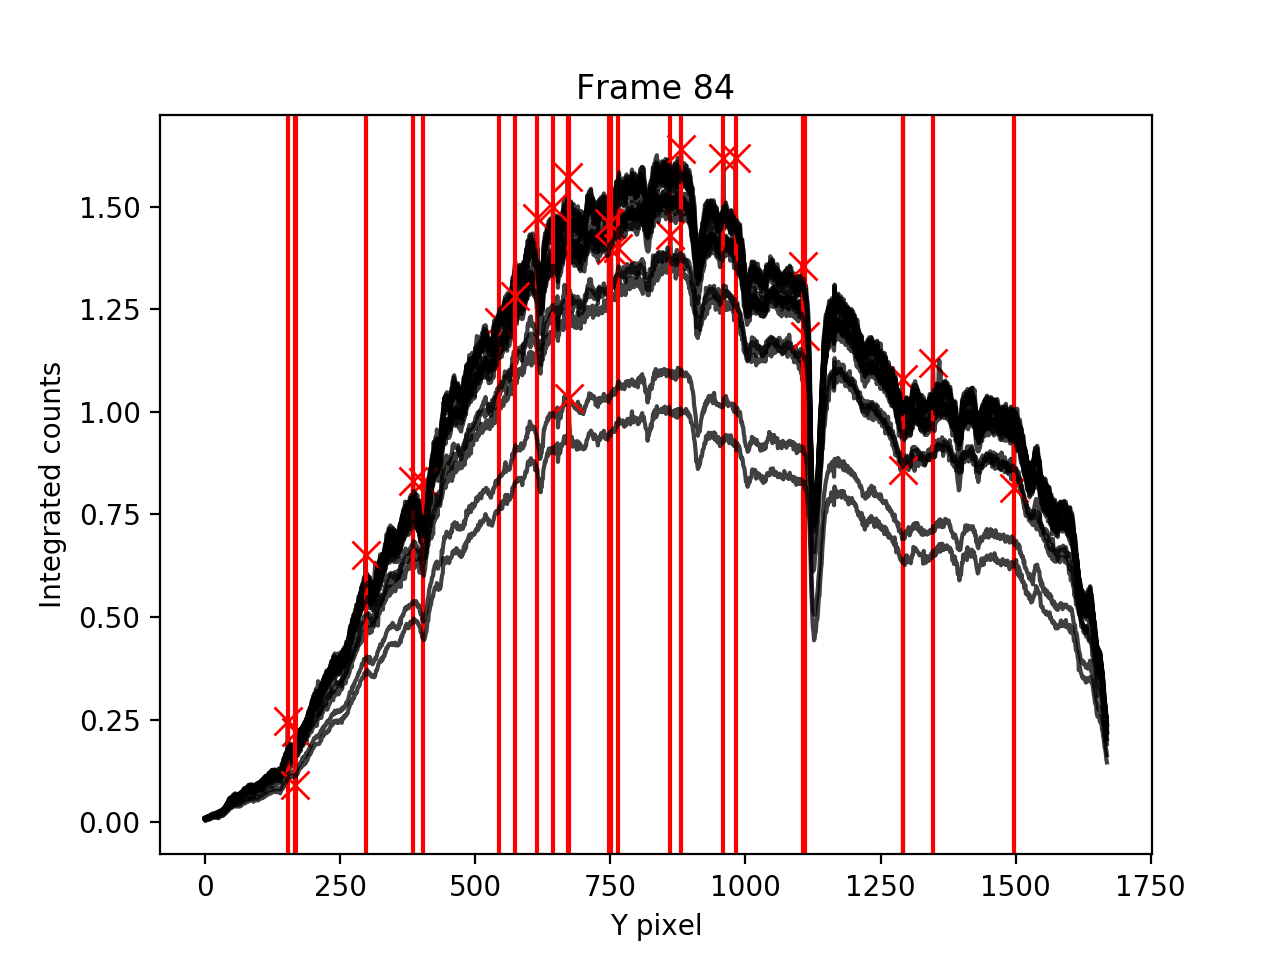

In [88]:
c.check_cosmic_frames(wc.normalise(s1),cosmic_frames_1_mf,cosmic_pixels_1_mf,single_plot=True)

For these spectra, the median filter has performed much better. This is not always the case so it is helpful to try both methods.

Now replace the cosmic frames again.

<IPython.core.display.Javascript object>


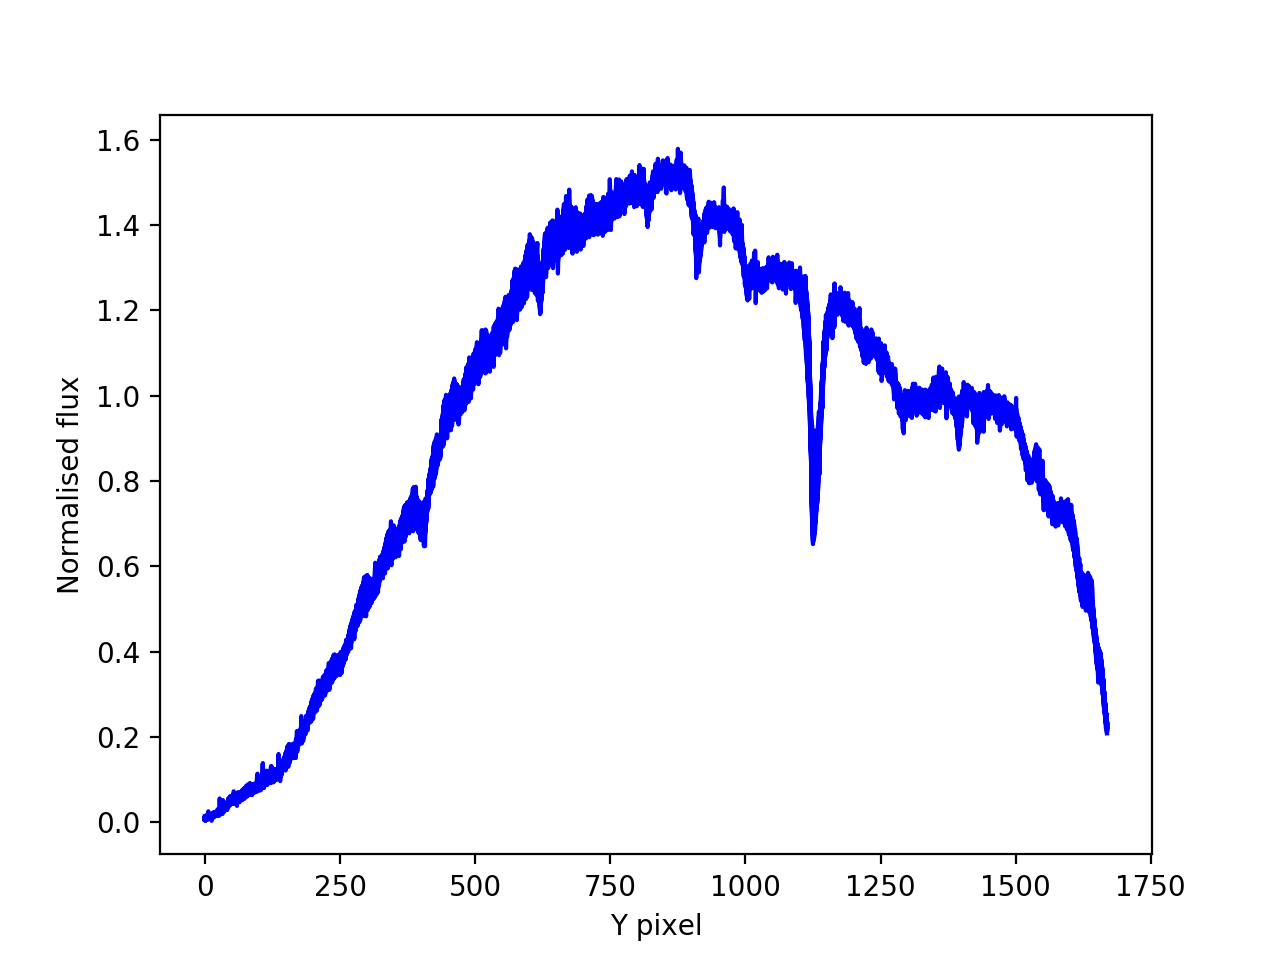

In [89]:
s1_copy,e1_copy = c.replace_cosmics(s1,e1,cosmic_frames_1_mf,cosmic_pixels_1_mf)

plt.figure()
for i in s1_copy:
    plt.plot(wc.normalise(i),'b')
plt.ylabel('Normalised flux')
plt.xlabel('Y pixel')
plt.show()

Again, there are still a couple of residual cosmics but overall much better.

Now do the same for star 2.

In [90]:
cosmic_frames_2_mf,pixels_2_mf = c.find_cosmic_frames_with_medfilt(s2,box_width=7,sigma_clip=9,\
                                                             mask=[list(range(520,526)),list(range(1160,1170))],\
                                                            use_mad=False)

print("Cosmic frames = ",cosmic_frames_2_mf)


Cosmic frames =  [10 23 29 34 46 55 57 62 70 71 79 83 84]


<IPython.core.display.Javascript object>


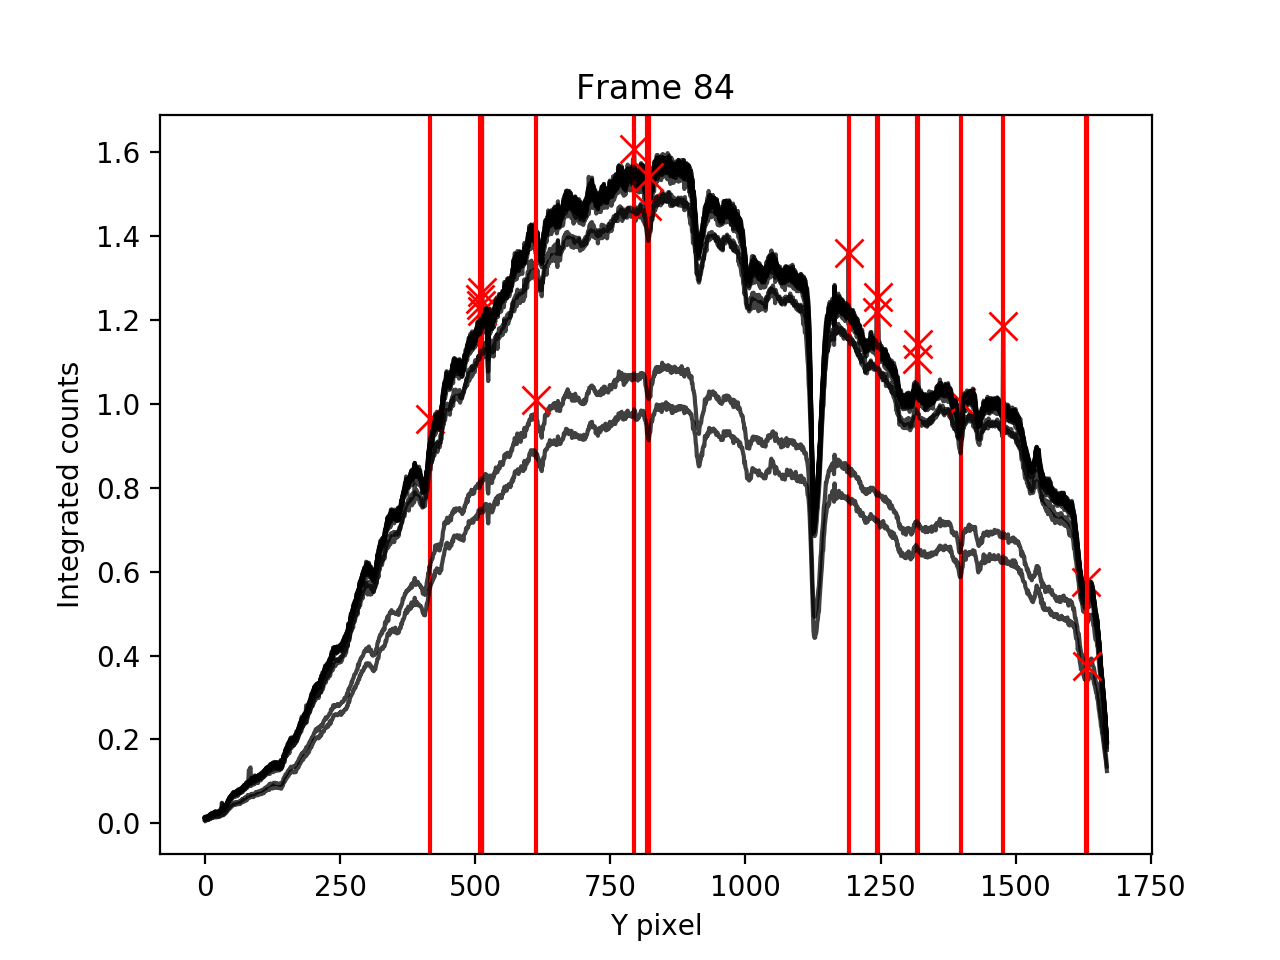

In [91]:
c.check_cosmic_frames(wc.normalise(s2),cosmic_frames_2_mf,pixels_2_mf,single_plot=True)


Again, this looks to have done a good job.

Now replace the cosmic frames.

<IPython.core.display.Javascript object>


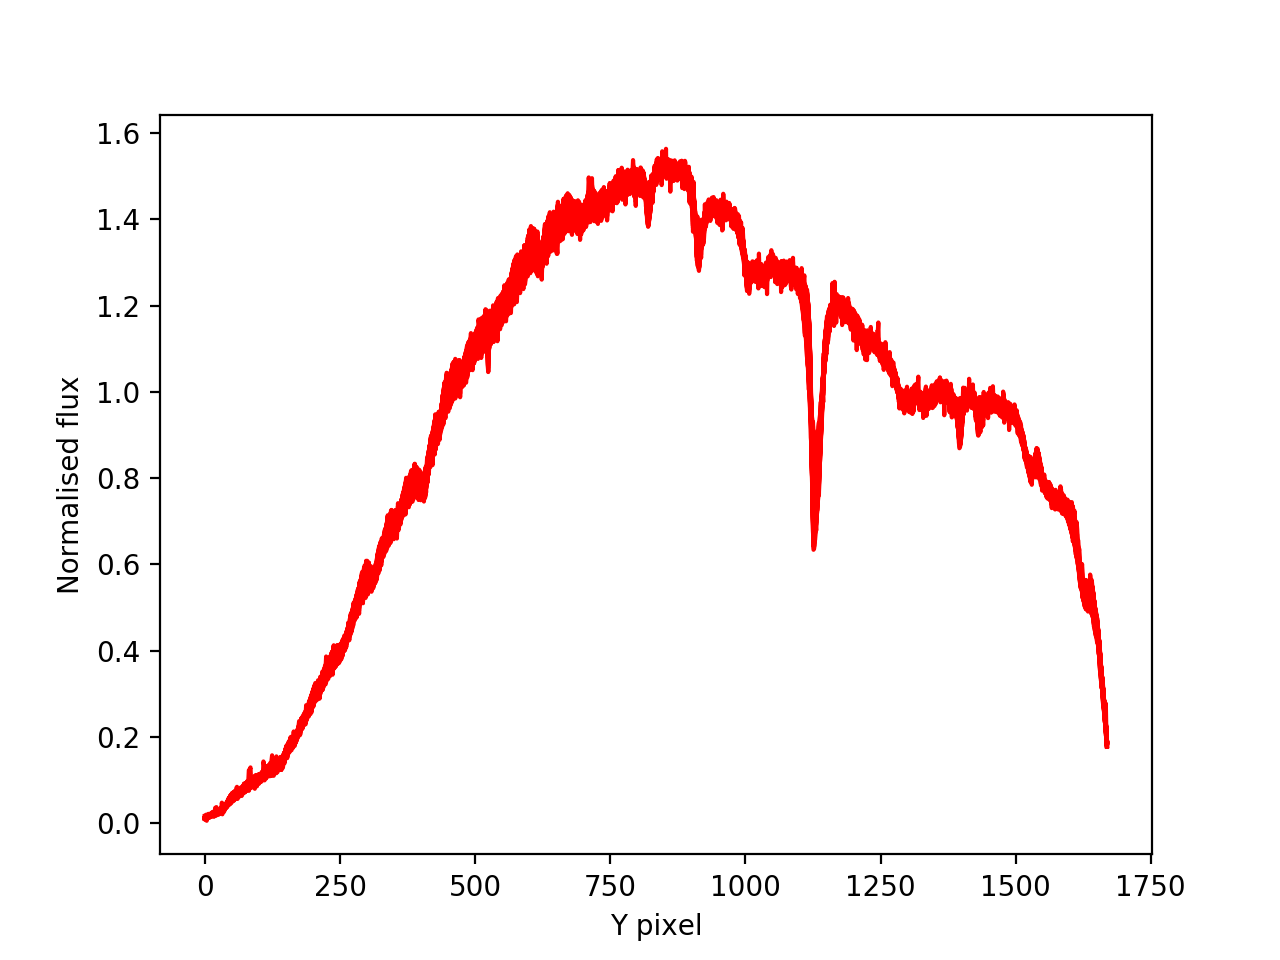

In [92]:
s2_copy,e2_copy = c.replace_cosmics(s2,e2,cosmic_frames_2_mf,pixels_2_mf)

plt.figure()
for i in s2_copy:
    plt.plot(wc.normalise(i),'r')
plt.ylabel('Normalised flux')
plt.xlabel('Y pixel')
plt.show()

This looks to have removed all the cosmic rays from star 2. Now save these arrays (pickle.dump). These are commented out for this example.

In [93]:
# pickle.dump(s1_copy,open('../pickled_objects/star1_flux_cleaned.pickle','wb'))
# pickle.dump(s2_copy,open('../pickled_objects/star2_flux_cleaned.pickle','wb'))

# pickle.dump(e1_copy,open('../pickled_objects/star1_error_cleaned.pickle','wb'))
# pickle.dump(e2_copy,open('../pickled_objects/star2_error_cleaned.pickle','wb'))

And check how the light curve compares before and after cosmic removal.

<IPython.core.display.Javascript object>


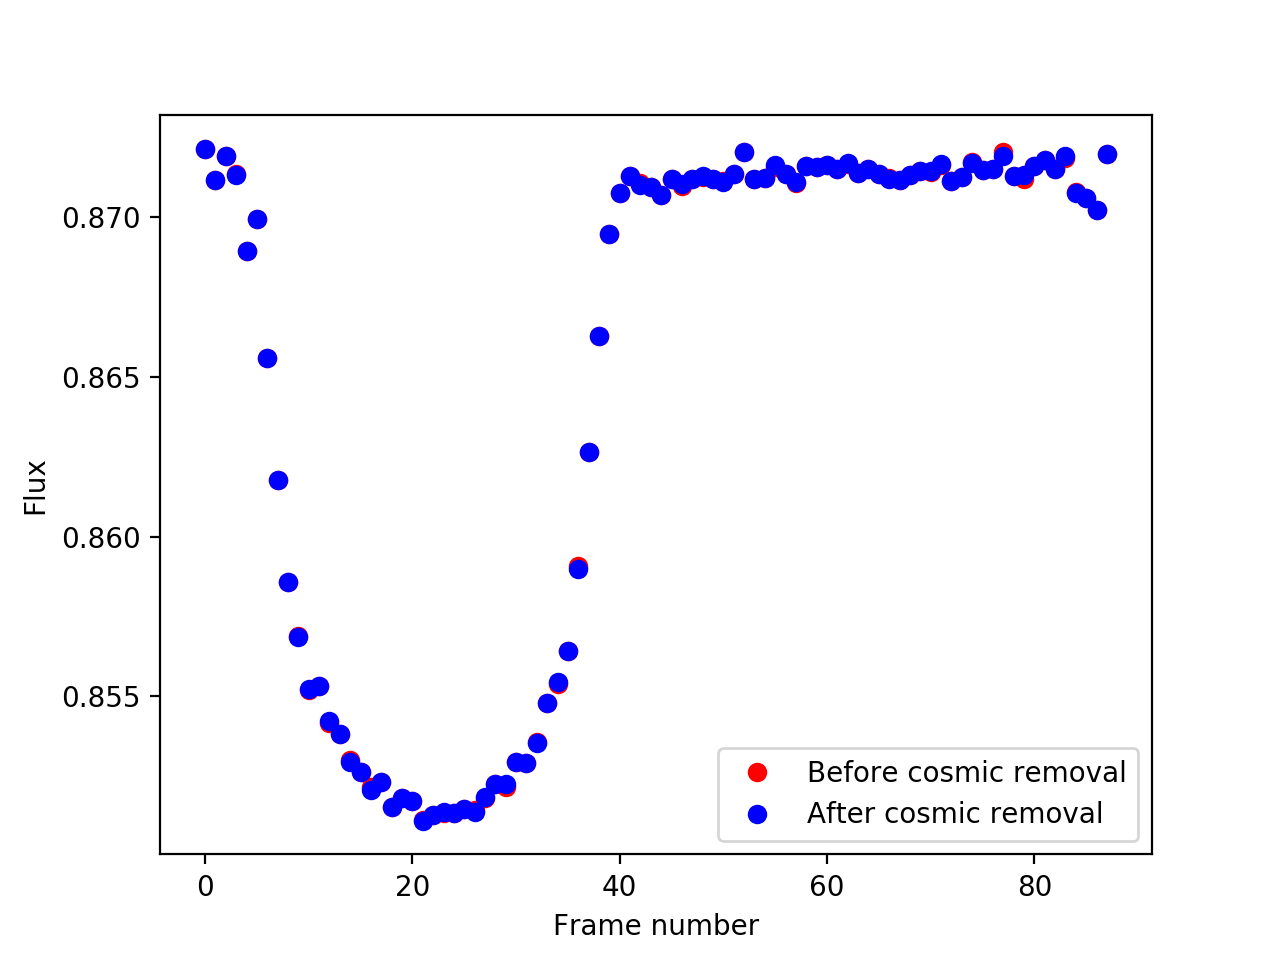

In [94]:
plt.figure()
plt.plot(s1.sum(axis=1)/s2.sum(axis=1),'ro',label='Before cosmic removal')
plt.plot(s1_copy.sum(axis=1)/s2_copy.sum(axis=1),'bo',label='After cosmic removal')
plt.legend(loc='lower right')
plt.ylabel('Flux')
plt.xlabel('Frame number')
plt.show()

In this case, there is very little difference as the cosmics were not too bad in this example.

Now we're done and can move to notebook 2.